# CMPUT 328 — Logistic Regression Lab Assignment

**Total Weight:** 5% of course grade  
**Part 1 (Lab):** 2%  
**Part 2 (Take-home):** 2%  
**Deadline:** Sunday, September 21

**Tools:** Google Colab + Gemini (AI assistance allowed, but cite and document).

---

## 🔧 Setup

In [ ]:
# Install PyTorch + torchvision (if needed)
# !pip install -q torch torchvision

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 📦 Data Preparation

In [ ]:
# Transform: normalize MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Download MNIST
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split into train (50k) and validation (10k)
train_size = 50_000
val_size = len(train_ds) - train_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 35.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.92MB/s]


(50000, 10000, 10000)

# Part 1 — In-Lab (2%)

Implement and train Logistic Regression on MNIST.  
Complete the following steps **during the lab (3 hours)**.

### 1. Baseline Logistic Regression

In [ ]:
# TODO: Define Logistic Regression model using nn.Linear(784, 10).
class LogisticRegression(nn.Module):
    def __init__(self, in_dim=28*28, out_dim=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))

model = LogisticRegression().to(device)
print(model)

LogisticRegression(
  (fc): Linear(in_features=784, out_features=10, bias=True)
)


### 2. Training Loop (SGD + CrossEntropyLoss)

In [ ]:
# TODO: Write training loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Optional: Add validation loop here to track performance during training
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Epoch [1/10], Loss: 0.3817
Validation Accuracy: 90.62%
Epoch [2/10], Loss: 0.3045
Validation Accuracy: 91.37%
Epoch [3/10], Loss: 0.2918
Validation Accuracy: 91.02%
Epoch [4/10], Loss: 0.2839
Validation Accuracy: 91.26%
Epoch [5/10], Loss: 0.2793
Validation Accuracy: 91.59%
Epoch [6/10], Loss: 0.2747
Validation Accuracy: 90.58%
Epoch [7/10], Loss: 0.2720
Validation Accuracy: 91.64%
Epoch [8/10], Loss: 0.2687
Validation Accuracy: 92.02%
Epoch [9/10], Loss: 0.2664
Validation Accuracy: 91.45%
Epoch [10/10], Loss: 0.2642
Validation Accuracy: 91.77%


### 3. Regularization (L2, L1)

In [ ]:
# TODO: Re-run training with L2 (via weight_decay).
# TODO: Implement manual L1 penalty and compare results.

print("Training with L2 Regularization:")
# Re-run training with L2 (via weight_decay)
criterion_l2 = nn.CrossEntropyLoss()
# Add weight_decay to the optimizer for L2 regularization
optimizer_l2 = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4) # You can adjust the weight_decay value

num_epochs_l2 = 10 # Using the same number of epochs for comparison
for epoch in range(num_epochs_l2):
    model.train()
    running_loss_l2 = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss_l2 = criterion_l2(outputs, labels)

        optimizer_l2.zero_grad()
        loss_l2.backward()
        optimizer_l2.step()

        running_loss_l2 += loss_l2.item()

    print(f"Epoch [{epoch+1}/{num_epochs_l2}], Loss with L2: {running_loss_l2/len(train_loader):.4f}")

print("\nTraining with Manual L1 Regularization:")
# Implement manual L1 penalty
criterion_l1 = nn.CrossEntropyLoss()
optimizer_l1 = torch.optim.SGD(model.parameters(), lr=0.1) # No weight_decay here

l1_lambda = 0.001  # Coefficient for L1 regularization - you can adjust this value

num_epochs_l1 = 10 # Using the same number of epochs for comparison
for epoch in range(num_epochs_l1):
    model.train()
    running_loss_l1 = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        # Calculate L1 norm
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        # Add L1 penalty to the loss
        loss_l1 = criterion_l1(outputs, labels) + l1_lambda * l1_norm

        optimizer_l1.zero_grad()
        loss_l1.backward()
        optimizer_l1.step()

        running_loss_l1 += loss_l1.item()

    print(f"Epoch [{epoch+1}/{num_epochs_l1}], Loss with L1: {running_loss_l1/len(train_loader):.4f}")

Training with L2 Regularization:
Epoch [1/10], Loss with L2: 0.2633
Epoch [2/10], Loss with L2: 0.2611
Epoch [3/10], Loss with L2: 0.2599
Epoch [4/10], Loss with L2: 0.2588
Epoch [5/10], Loss with L2: 0.2571
Epoch [6/10], Loss with L2: 0.2572
Epoch [7/10], Loss with L2: 0.2548
Epoch [8/10], Loss with L2: 0.2556
Epoch [9/10], Loss with L2: 0.2544
Epoch [10/10], Loss with L2: 0.2530

Training with Manual L1 Regularization:
Epoch [1/10], Loss with L1: 0.6278
Epoch [2/10], Loss with L1: 0.5161
Epoch [3/10], Loss with L1: 0.4769
Epoch [4/10], Loss with L1: 0.4619
Epoch [5/10], Loss with L1: 0.4551
Epoch [6/10], Loss with L1: 0.4517
Epoch [7/10], Loss with L1: 0.4504
Epoch [8/10], Loss with L1: 0.4497
Epoch [9/10], Loss with L1: 0.4481
Epoch [10/10], Loss with L1: 0.4469


### 4. Optimizer Swap

In [ ]:
# TODO: Replace SGD with Adam optimizer and compare convergence speed. You can try plotting the loss or accuracy curves

print("Training with Adam Optimizer:")
criterion_adam = nn.CrossEntropyLoss()
# Replace SGD with Adam optimizer
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001) # You can adjust the learning rate for Adam

num_epochs_adam = 10 # Using the same number of epochs for comparison
for epoch in range(num_epochs_adam):
    model.train()
    running_loss_adam = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss_adam = criterion_adam(outputs, labels)
        optimizer_adam.zero_grad()
        loss_adam.backward()
        optimizer_adam.step()

        running_loss_adam += loss_adam.item()

    print(f"Epoch [{epoch+1}/{num_epochs_adam}], Loss with Adam: {running_loss_adam/len(train_loader):.4f}")
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Training with Adam Optimizer:
Epoch [1/10], Loss with Adam: 0.2938
Validation Accuracy: 91.61%
Epoch [2/10], Loss with Adam: 0.2766
Validation Accuracy: 91.88%
Epoch [3/10], Loss with Adam: 0.2688
Validation Accuracy: 91.84%
Epoch [4/10], Loss with Adam: 0.2646
Validation Accuracy: 91.87%
Epoch [5/10], Loss with Adam: 0.2612
Validation Accuracy: 91.95%
Epoch [6/10], Loss with Adam: 0.2576
Validation Accuracy: 92.02%
Epoch [7/10], Loss with Adam: 0.2553
Validation Accuracy: 92.05%
Epoch [8/10], Loss with Adam: 0.2531
Validation Accuracy: 91.81%
Epoch [9/10], Loss with Adam: 0.2514
Validation Accuracy: 91.96%
Epoch [10/10], Loss with Adam: 0.2499
Validation Accuracy: 91.98%


### 5. Visualization of Learned Weights

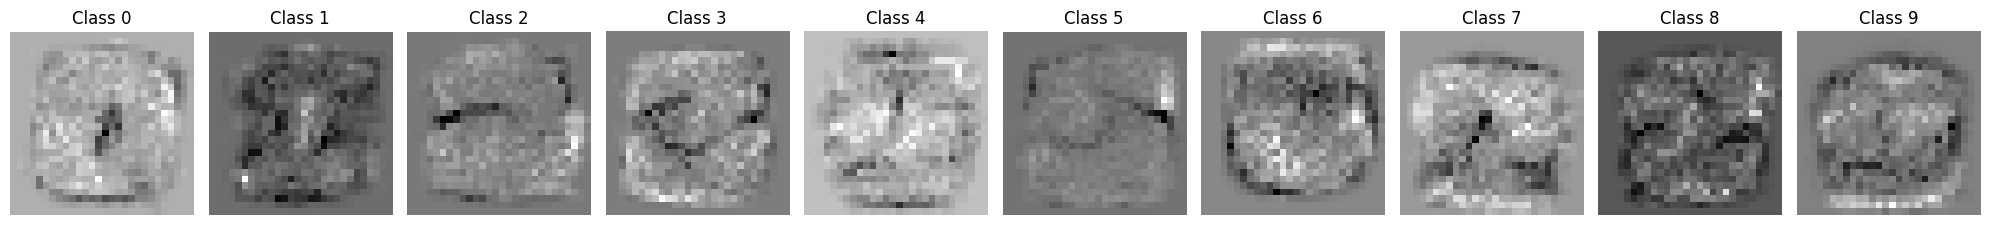

In [ ]:
# TODO: Plot each class’s weight vector as 28x28 image.

# Get the weights from the linear layer
weights = model.fc.weight.data.cpu() # Move weights to CPU for numpy conversion and plotting

fig, axes = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    # Reshape the weight vector for the i-th class to 28x28
    weight_image = weights[i].view(28, 28)

    # Plot the image
    ax = axes[i]
    ax.imshow(weight_image, cmap='gray')
    ax.set_title(f'Class {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Part 2 — Take-Home (2%)

Extend your experiments and write a short (≈1 page) report.  
**Deadline:** One week after the lab.

### 1. Confusion Matrix

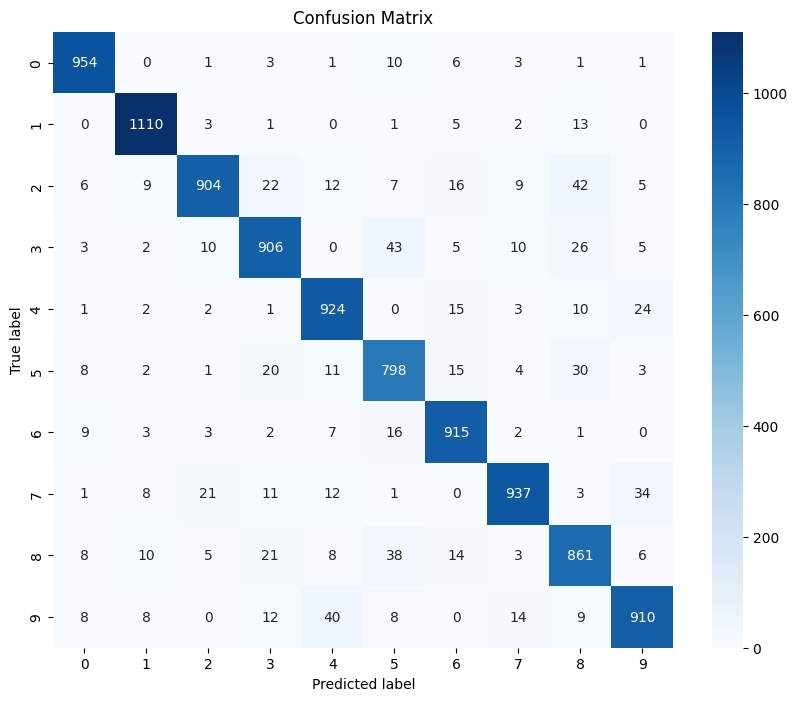

In [ ]:
# TODO: Compute confusion matrix on test set predictions.
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn for better visualization

# Initialize empty lists to store predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
# Use seaborn.heatmap for a more visually appealing confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

### 2. Reduced Training Data

Training with 10.0% of the training data...
Validation Accuracy with 6000 training samples: 90.21%
Training with 25.0% of the training data...
Validation Accuracy with 15000 training samples: 90.86%
Training with 50.0% of the training data...
Validation Accuracy with 30000 training samples: 92.39%


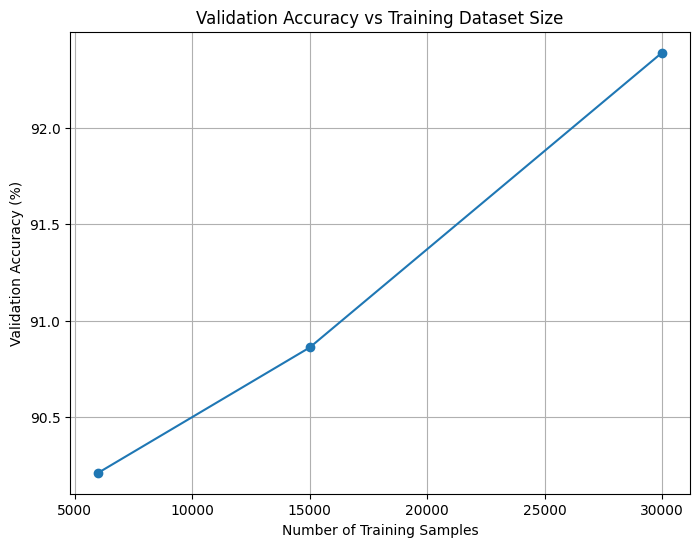

In [ ]:
# TODO: Train logistic regression with only 10%, 25%, 50% of train data.
# Plot validation accuracy vs dataset size.

dataset_sizes = [0.1, 0.25, 0.5] # Percentages of training data to use
accuracies = []
train_sizes = []

# Get the original training dataset
original_train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

for size_ratio in dataset_sizes:
    print(f"Training with {size_ratio*100}% of the training data...")

    # Calculate the number of samples for the current size ratio
    num_samples = int(len(original_train_ds) * size_ratio)
    # Ensure the number of samples is at least 1
    if num_samples == 0 and size_ratio > 0:
        num_samples = 1

    # Create a subset of the training data
    subset_train_ds, _ = random_split(original_train_ds, [num_samples, len(original_train_ds) - num_samples])
    subset_train_loader = DataLoader(subset_train_ds, batch_size=batch_size, shuffle=True)

    # Initialize a new model for each training run
    model_subset = LogisticRegression().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_subset.parameters(), lr=0.1)

    # Train the model on the subset
    num_epochs_subset = 10 # You can adjust the number of epochs
    for epoch in range(num_epochs_subset):
        model_subset.train()
        running_loss = 0.0
        for images, labels in subset_train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_subset(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Optional: print loss for each epoch
        # print(f"  Epoch [{epoch+1}/{num_epochs_subset}], Loss: {running_loss/len(subset_train_loader):.4f}")


    # Evaluate the model on the validation set
    model_subset.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_subset(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    train_sizes.append(num_samples)
    print(f"Validation Accuracy with {num_samples} training samples: {accuracy:.2f}%")

# Plot validation accuracy vs dataset size
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, accuracies, marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Training Dataset Size')
plt.grid(True)
plt.show()

### 3. Noisy Labels

In [ ]:
# TODO: Randomly flip 10% of training labels, retrain, and measure accuracy drop.

# Make a copy of the original training dataset labels
noisy_train_labels = train_ds.dataset.targets.clone() # Assuming train_ds is a Subset or ConcatDataset, get the original targets

# Calculate the number of labels to flip (10%)
num_labels_to_flip = int(len(noisy_train_labels) * 0.1)

# Get random indices to flip
flip_indices = torch.randperm(len(noisy_train_labels))[:num_labels_to_flip]

# Flip the labels
for i in flip_indices:
    original_label = noisy_train_labels[i]
    # Get a list of all possible labels
    all_labels = list(range(10))
    # Remove the original label
    all_labels.remove(original_label.item())
    # Choose a new random label from the remaining labels
    new_label = torch.tensor(np.random.choice(all_labels))
    # Assign the new label
    noisy_train_labels[i] = new_label

# Create a new dataset with the noisy labels
# Note: This is a simplified way to create a dataset with modified targets.
# For more complex cases, you might need to create a custom Dataset class.
noisy_train_ds = torch.utils.data.TensorDataset(train_ds.dataset.data, noisy_train_labels)

# Split the noisy dataset into training and validation sets again (optional, but good practice if you used random_split before)
# Ensure the split sizes are consistent with the original split
original_train_size = 50000 # Use the original train_size defined in Data Preparation
original_val_size = 10000  # Use the original val_size defined in Data Preparation

if len(noisy_train_ds) != (original_train_size + original_val_size):
     print("Warning: Noisy dataset size does not match original. Adjusting split size.")
     original_train_size = int(len(noisy_train_ds) * 5/6) # Assuming a 5/6 train, 1/6 val split
     original_val_size = len(noisy_train_ds) - original_train_size


noisy_train_ds, noisy_val_ds = random_split(noisy_train_ds, [original_train_size, original_val_size])


# Create a DataLoader for the noisy training data
noisy_train_loader = DataLoader(noisy_train_ds, batch_size=batch_size, shuffle=True)

# Now you can train a new model using noisy_train_loader and evaluate on the original val_loader or test_loader
print(f"Created a noisy training dataset with {num_labels_to_flip} flipped labels.")

# TODO: Retrain a new model using noisy_train_loader and measure accuracy drop compared to training with original data.
# Example of retraining:
# model_noisy = LogisticRegression().to(device)
# criterion_noisy = nn.CrossEntropyLoss()
# optimizer_noisy = torch.optim.SGD(model_noisy.parameters(), lr=0.1)
# # Training loop with noisy_train_loader...
# # Evaluate model_noisy on val_loader or test_loader and compare accuracy with the original model's accuracy.

Created a noisy training dataset with 6000 flipped labels.


### 4. Short Report

- Which regularization worked better (L1 vs L2)?  
- Which optimizer was more effective (SGD vs Adam)?  
- What does the confusion matrix reveal?  
- How does performance degrade with reduced or noisy data?  
- How did Gemini help (include sample prompts + modifications)?